<a href="https://colab.research.google.com/github/tmiessa/mdc-defaultcredit/blob/development/mdc_defaultcredit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MDC 2019 - INF-0619 - Default of Credit Cards


## Alunos
* Matheus Pacheco
* Raphael Santos
* Renato Dias
* Tiago Miessa

## Imports

In [0]:
import sys
import os 
import requests
from datetime import date

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.utils import resample

## Download do Dataset

In [29]:
## download files
if os.path.isfile('UCI_Credit_Card.csv'):
    print('file already exists!')
else:
    print('file does not exists, downloading...')
    myfile = requests.get('https://onedrive.live.com/download?cid=F1E435813B40678A&resid=F1E435813B40678A%218086&authkey=AE0BdkzcP5BTU-M')
    open('UCI_Credit_Card.csv', 'wb').write(myfile.content)
    print('file downloaded')

file already exists!


In [0]:
df = pd.read_csv('UCI_Credit_Card.csv')

# Rename de coluna fora do padrão e do target, para facilitar referência futura
df.rename(columns={'PAY_0':'PAY_1','default.payment.next.month':'DEFAULTED'}, inplace=True)

In [31]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULTED
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


## Análise Exploratória Inicial

### Verificação de Consistência das Features

In [32]:
df[['LIMIT_BAL', 'AGE']].describe()

,LIMIT_BAL,AGE
count,30000.000000,30000.000000
mean,167484.322667,35.485500
std,129747.661567,9.217904
min,10000.000000,21.000000
25%,50000.000000,28.000000
50%,140000.000000,34.000000
75%,240000.000000,41.000000
max,1000000.000000,79.000000


A feature `LIMIT_BAL`, que indica o limite de crédito do cartão, varia de 10.000 a 1.000.000 NT Dólares, e a idade varia de 21 a 79 anos.


In [33]:
df[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].describe()

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100
std,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


In [34]:
df[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].apply(pd.Series.value_counts).fillna(0).astype(int)

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
-2,2759,3782,4085,4348,4546,4895
-1,5686,6050,5938,5687,5539,5740
0,14737,15730,15764,16455,16947,16286
1,3688,28,4,2,0,0
2,2667,3927,3819,3159,2626,2766
3,322,326,240,180,178,184
4,76,99,76,69,84,49
5,26,25,21,35,17,13
6,11,12,23,5,4,19
7,9,20,27,58,58,46


**Features PAY_X**

As features `PAY_X` indicam o pagamento dos meses de Setembro de 2005 a Abril 2005, onde podem assumir os seguintes valores:

* **`-1:`** pago devidamente
* **`1:`** atraso no pagamento de 1 mês
* **`2:`** atraso no pagamento de 2 meses
* **`X:`** atraso no pagamento de X meses (limite superior = 9)

**Problemas encontrados:**

*   Valores -2 e 0, sem documentação





In [35]:
df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000
mean,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400
std,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000
50%,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000
75%,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


**Features BILL_AMTX**

As features `BILL_AMTX` indicam o valor da fatura do cartão de crédito nos meses de Setembro 2005 (BILL_AMT1) a Abril 2005 (BILL_AMT6)

**Problemas encontrados:**

* Foram encontrados valores negativos em todos os meses.

In [36]:
df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


In [37]:
df[['SEX','EDUCATION', 'MARRIAGE']].describe()

,SEX,EDUCATION,MARRIAGE
count,30000.000000,30000.000000,30000.000000
mean,1.603733,1.853133,1.551867
std,0.489129,0.790349,0.521970
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000
max,2.000000,6.000000,3.000000


In [38]:
df[['SEX','EDUCATION', 'MARRIAGE']].apply(pd.Series.value_counts).fillna(0).astype(int)

,SEX,EDUCATION,MARRIAGE
0,0,14,54
1,11888,10585,13659
2,18112,14030,15964
3,0,4917,323
4,0,123,0
5,0,280,0
6,0,51,0


**Features SEX, EDUCATION e MARRIAGE**

* **`SEX:`** indica o gênero do cliente (1: masculino, 2: feminino)
* **`EDUCATION:`** nível de educação do cliente (1: graduate school, 2: university, 3: high school, 4: others, 5: desconhecido, 6: desconhecido)
* **`MARRIAGE:`** status marital (1: casado, 2: solteiro, 3: outros)

**Problemas Encontrados:**

* Valores não documentados para **`EDUCATION`** (0, 5, e 6)
* Valores não documentados para **`MARRIAGE`** (0)

In [39]:
df['DEFAULTED'].value_counts()

0    23364
1     6636
Name: DEFAULTED, dtype: int64

### Investigação da Distribuição dos Dados

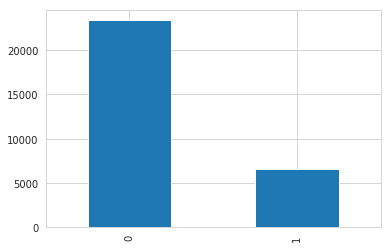

In [40]:
df['DEFAULTED'].value_counts().plot(kind='bar');

## Pivotamento (para análise futura)

Para facilitar a análise de evolução no tempo das colunas PAY_N, BILL_AMTN e PAY_AMTN, definimos o método abaixo para fazer o pivotamento das informações:

In [0]:
def pivotAgg(row1):
    res = np.concatenate( ( 
        [row1[['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1','BILL_AMT1','PAY_AMT1','DEFAULTED']].append(pd.Series({'DATE':date(2005,9,1)}))],
        [row1[['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_2','BILL_AMT2','PAY_AMT2','DEFAULTED']].append(pd.Series({'DATE':date(2005,8,1)}))],
        [row1[['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_3','BILL_AMT3','PAY_AMT3','DEFAULTED']].append(pd.Series({'DATE':date(2005,7,1)}))],
        [row1[['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_4','BILL_AMT4','PAY_AMT4','DEFAULTED']].append(pd.Series({'DATE':date(2005,6,1)}))],
        [row1[['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_5','BILL_AMT5','PAY_AMT5','DEFAULTED']].append(pd.Series({'DATE':date(2005,5,1)}))],
        [row1[['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_6','BILL_AMT6','PAY_AMT6','DEFAULTED']].append(pd.Series({'DATE':date(2005,4,1)}))]
    ))
    return res

# Outra ideia a ser explorada: usar o melt para cada coluna alvo, ao invés de todas de uma vez (value_vars not set: everything else)
# test = df.melt(id_vars=['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE'])
# test.reset_index(drop=True,inplace=True)
# test.head()

In [0]:
pdf = pd.DataFrame(np.concatenate([ pivotAgg(row[1]) for row in df.iterrows()]))
pdf.columns = ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAYMENT STATUS','BILL AMOUNT','PAID AMOUNT','DEFAULTED', 'DATE']
pdf.to_csv('UCI_Credit_Card_Pivoted.csv', index=False)

Um ponto interessante é que o banco recebe muito menos do que o devido, com cerca de 11%:

In [43]:
pdf['PAID AMOUNT'].sum()/pdf['BILL AMOUNT'].sum()

0.11728746963554218

## Construção do Baseline

Serão construídos dois modelos, para verificação da acurácia antes que qualquer pré-processamento (com exceção de normalização) seja feito nos dados. O motivo para isso é que o problema pode estar na descrição, ao invés de no conjunto.



In [0]:
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,:-1],df.iloc[:,-1], test_size=0.3, random_state=42 )

scaler = StandardScaler()

z_train = scaler.fit_transform(x_train)
z_test = scaler.transform(x_test)

### Regressão Logística

In [45]:
## split train and test set
y = df['DEFAULTED'].values
x = df[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].values
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, stratify=y, random_state=42)


print('different values of y: %s' % np.unique(y))

print('y_train distribution - label0: %d / label1: %d' % (len(y_train)-sum(y_train), sum(y_train)))
print('y_test distribution - label0: %d / label1: %d' % (len(y_test)-sum(y_test), sum(y_test)))


different values of y: [0 1]
y_train distribution - label0: 16324 / label1: 4676
y_test distribution - label0: 7040 / label1: 1960


In [0]:
## downsampling class 0
#tmp_nopay = np.column_stack((x_train[y_train==0], y_train[y_train==0]))
#tmp_pay = np.column_stack((x_train[y_train==1], y_train[y_train==1]))

In [0]:
#tmp_nopay = resample(tmp_nopay, replace=False, n_samples=len(y_train[y_train==1]), random_state=42)
#tmp_downsampled = np.concatenate([tmp_nopay, tmp_pay])

In [0]:
#x_train_resampled = tmp_downsampled[:,:-1]
#y_train_resampled = tmp_downsampled[:,-1:]

Logistic Regression
Balanced Accuracy: 66.97%


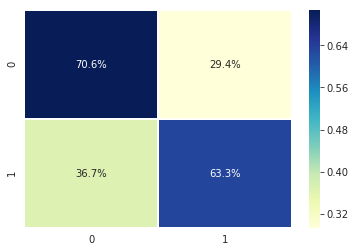

In [58]:
## logistic regression
# logreg = LogisticRegression(random_state=42, class_weight='balanced').fit(x_train, y_train)
# y_pred = logreg.predict(x_test)
logreg = LogisticRegression(random_state=42, solver = 'lbfgs', class_weight='balanced').fit(z_train, y_train)
y_pred = logreg.predict(z_test)
cm = confusion_matrix(y_test, y_pred)

print('Logistic Regression')
print('Balanced Accuracy: %.2f%%' % (balanced_accuracy_score(y_test, y_pred)*100))

sns.set_style("whitegrid")
plt.figure(figsize=(6, 4))
# Matriz de Confusão:
# 	Linhas: Real
# 	Colunas: Predito

r = cm/cm.sum(axis=1)[:,np.newaxis]
sns.heatmap(r, linewidths=.5, cmap='YlGnBu', annot=True, fmt='.1%');

### SVM

In [59]:
# C foi alterado de 0.001 a 10, melhor valor foi 1 (que é o default)
svm = SVC(kernel='rbf', C=1, class_weight='balanced', random_state=999)
svm.fit(z_train, y_train)

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=999,
    shrinking=True, tol=0.001, verbose=False)

SVM - SVC
Balanced Accuracy: 69.94%


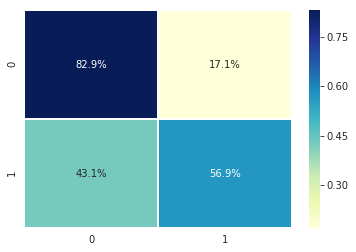

In [60]:
predictions = svm.predict(z_test)

print('SVM - SVC')
print('Balanced Accuracy: %.2f%%' % (balanced_accuracy_score(y_test, predictions)*100))

c = confusion_matrix(y_test, predictions)
r = c / c.sum(axis=1)[:, np.newaxis]

sns.set_style("whitegrid")
plt.figure(figsize=(6, 4))
# Matriz de Confusão:
# 	Linhas: Real
# 	Colunas: Predito
sns.heatmap(r, linewidths=.5, cmap='YlGnBu', annot=True, fmt='.1%');

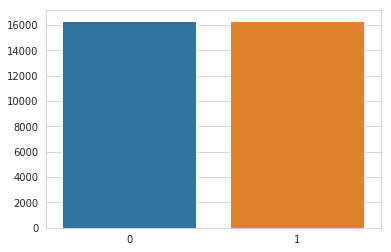

In [61]:
# Dados estão desbalanceados - usar um SMOTE ajudaria?
# Para o SVM provavelmente não, por conta de toda a ideia por trás dele. Mas checarei de qualquer maneira, para ter certeza

smoter = SMOTE(sampling_strategy = 'minority', random_state=777)
sz_train, sy_train = smoter.fit_resample(z_train, y_train)

defaultedS = np.unique(sy_train, return_counts=True)
sns.barplot(defaultedS[0],defaultedS[1])

In [62]:
svmS = SVC(kernel='rbf', C=1, random_state=999)
svmS.fit(sz_train, sy_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=999,
    shrinking=True, tol=0.001, verbose=False)

SVM - SVC SMOTED
Balanced Accuracy: 70.01%


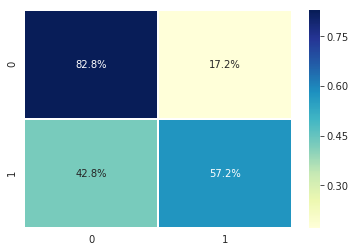

In [64]:
predictions = svmS.predict(z_test)

print('SVM - SVC SMOTED')
print('Balanced Accuracy: %.2f%%' % (balanced_accuracy_score(y_test, predictions)*100))

c = confusion_matrix(y_test, predictions)
r = c / c.sum(axis=1)[:, np.newaxis]

sns.set_style("whitegrid")
plt.figure(figsize=(6, 4))
# Matriz de Confusão:
# 	Linhas: Real
# 	Colunas: Predito
sns.heatmap(r, linewidths=.5, cmap='YlGnBu', annot=True, fmt='.1%');

## Análise Aprofundada dos Dados